In [1]:
# Code that allows for manual editing of packages
%load_ext autoreload
%autoreload 2

# Data
In order to create a Quantum Convolutional Neural Network, we require an adequate dataset. Through testing with qiskit, I discovered that there was a limit to the size of the inputs, as well as that sizes on the upper end tended to take too long to run. To that end, I encoded the MNIST dataset into a 1D dataset, while retaining relative positional values and pixels. More information can be found here: [Scaling Down Deep Learning with MNIST-1D](https://arxiv.org/abs/2011.14439)

In [2]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

In [3]:
def get_templates():
    d0 = np.asarray([5,6,6.5,6.75,7,7,7,7,6.75,6.5,6,5])
    d1 = np.asarray([5,3,3,3.4,3.8,4.2,4.6,5,5.4,5.8,5,5])
    d2 = np.asarray([5,6,6.5,6.5,6,5.25,4.75,4,3.5,3.5,4,5])
    d3 = np.asarray([5,6,6.5,6.5,6,5,5,6,6.5,6.5,6,5])
    d4 = np.asarray([5,4.4,3.8,3.2,2.6,2.6,5,5,5,5,5,5])
    d5 = np.asarray([5,3,3,3,3,5,6,6.5,6.5,6,4.5,5])
    d6 = np.asarray([5,4,3.5,3.25,3,3,3,3,3.25,3.5,4,5])
    d7 = np.asarray([5,7,7,6.6,6.2,5.8,5.4,5,4.6,4.2,5,5])
    d8 = np.asarray([5,4,3.5,3.5,4,5,5,4,3.5,3.5,4,5])
    d9 = np.asarray([5,4,3.5,3.5,4,5,5,5,5,4.7,4.3,5])
    
    x = np.stack([d0,d1,d2,d3,d4,d5,d6,d7,d8,d9])
    x -= x.mean(1,keepdims=True) # whiten
    x /= x.std(1,keepdims=True)
    x -= x[:,:1]  # signal starts and ends at 0
    
    templates = {'x': x/6., 't': np.linspace(-5, 5, len(d0))/6.,
                 'y': np.asarray([0,1,2,3,4,5,6,7,8,9])}
    return templates

def plot_signals(xs, t, labels=None, args=None, ratio=2.6, do_transform=False, dark_mode=False, zoom=1):
    rows, cols = 1, 10
    fig = plt.figure(figsize=[cols*1.5,rows*1.5*ratio], dpi=60)
    for r in range(rows):
        for c in range(cols):
            ix = r*cols + c
            x, t = xs[ix], t
            ax = plt.subplot(rows,cols,ix+1)

            # plot the data
            if do_transform:
                assert args is not None, "Need an args object in order to do transforms"
                x, t = transform(x, t, args)  # optionally, transform the signal in some manner
            if dark_mode:
                plt.plot(x, t, 'wo', linewidth=6)
                ax.set_facecolor('k')
            else:
                plt.plot(x, t, 'k-', linewidth=2)
            if labels is not None:
                plt.title("label=" + str(labels[ix]), fontsize=22)

            plt.xlim(-zoom,zoom) ; plt.ylim(-zoom,zoom)
            plt.gca().invert_yaxis() ; plt.xticks([], []), plt.yticks([], [])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout() ; plt.show()
    return fig

In [4]:
from IPython.display import Image
from IPython.core.display import HTML 
print("Examples from original MNIST dataset:")
URL = 'https://raw.githubusercontent.com/greydanus/mnist1d/master/static/mnist.png'
Image(url= URL,  width=800)

Examples from original MNIST dataset:


Templates for the MNIST-1D dataset:


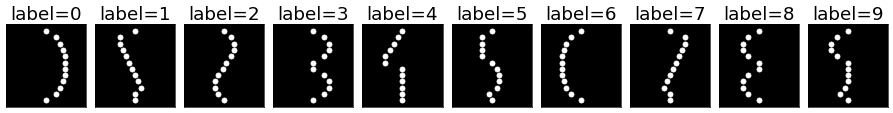

In [5]:
templates = get_templates()
print("Templates for the MNIST-1D dataset:")
x = templates['x']
t = templates['t']
y = templates['y']
fig = plot_signals(x, t, labels=y, ratio=1.33, dark_mode=True)

Templates for the MNIST-1D dataset:


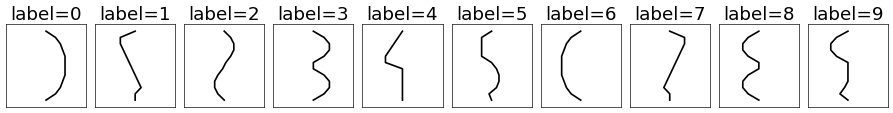

In [6]:
templates = get_templates()
print("Templates for the MNIST-1D dataset:")
x = templates['x']
t = templates['t']
y = templates['y']
fig = plot_signals(x, t, labels=y, ratio=1.33, dark_mode=False)

In [7]:
def pad(x, padding):
    low, high = padding
    p = low + int(np.random.rand()*(high-low+1))
    return np.concatenate([x, np.zeros((p))])

def shear(x, scale=10):
    coeff = scale*(np.random.rand() - 0.5)
    return x - coeff*np.linspace(-0.5,.5,len(x))

def translate(x, max_translation):
    k = np.random.choice(max_translation)
    return np.concatenate([x[-k:], x[:-k]])

def corr_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return gaussian_filter(noise, 2)

def iid_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return noise

def interpolate(x, N):
    scale = np.linspace(0,1,len(x))
    new_scale = np.linspace(0,1,N)
    new_x = interp1d(scale, x, axis=0, kind='linear')(new_scale)
    return new_x

def transform(x, y, args, eps=1e-8):
    new_x = pad(x+eps, args.padding) # pad
    new_x = interpolate(new_x, args.template_len + args.padding[-1])  # dilate
    new_y = interpolate(y, args.template_len + args.padding[-1])
    new_x *= (1 + args.scale_coeff*(np.random.rand() - 0.5))  # scale
    new_x = translate(new_x, args.max_translation)  #translate
    
    # add noise
    mask = new_x != 0
    new_x = mask*new_x + (1-mask)*corr_noise_like(new_x, args.corr_noise_scale)
    new_x = new_x + iid_noise_like(new_x, args.iid_noise_scale)
    
    # shear and interpolate
    new_x = shear(new_x, args.shear_scale)
    new_x = interpolate(new_x, args.final_seq_length) # subsample
    new_y = interpolate(new_y, args.final_seq_length)
    return new_x, new_y

def get_dataset_args(as_dict=False):
    arg_dict = {'num_samples': 500,
            'train_split': 0.8,
            'template_len': 12,
            'padding': [36,60],
            'scale_coeff': .4, 
            'max_translation': 48,
            'corr_noise_scale': 0.25,
            'iid_noise_scale': 2e-2,
            'shear_scale': 0.75,
            'shuffle_seq': False,
            'final_seq_length': 16,
            'seed': 42}
    return arg_dict if as_dict else ObjectView(arg_dict)

## Generating Data
Here, the step by step generation of the new data is shown. I used 16 values for each point, limiting input size to work with the constraints of qiskit.

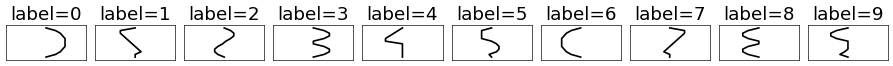

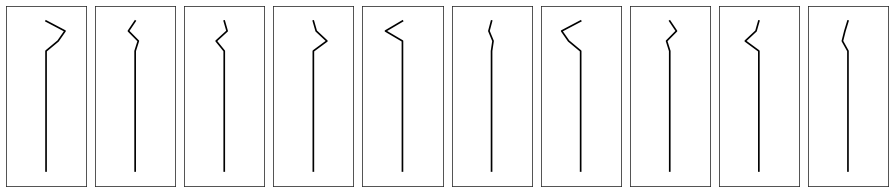

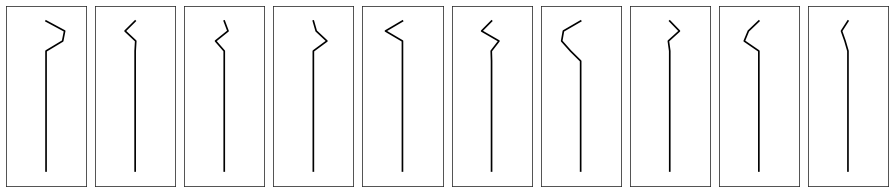

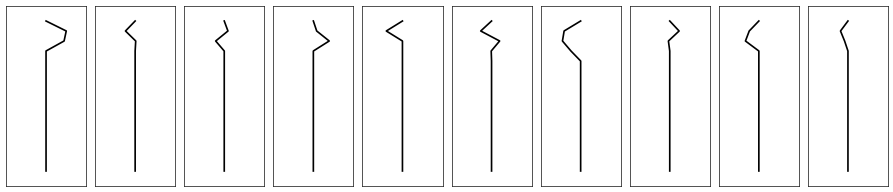

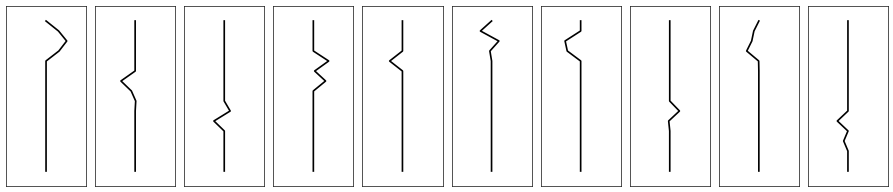

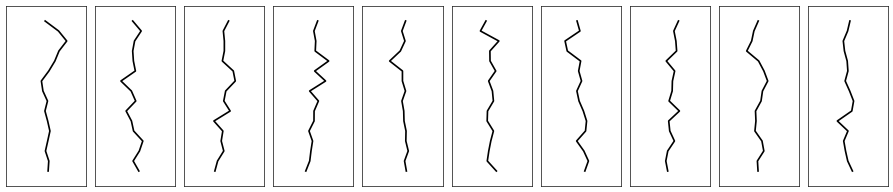

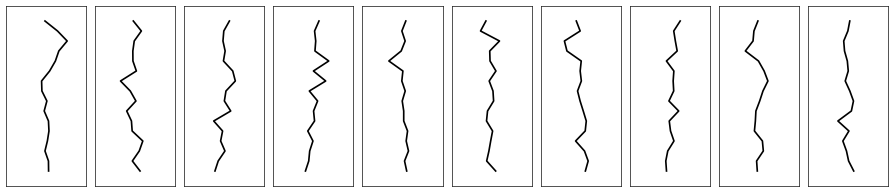

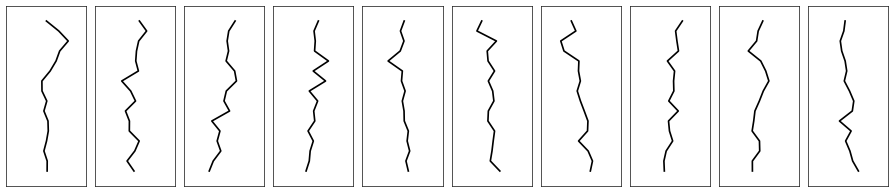

In [8]:
def apply_ablations(arg_dict, n=7):
    ablations = [('shear_scale', 0),
                ('iid_noise_scale', 0),
                ('corr_noise_scale', 0),
                 ('max_translation', 1),
                 ('scale_coeff', 0),
                 ('padding', [arg_dict['padding'][-1], arg_dict['padding'][-1]]),
                 ('padding', [0, 0]),]
    num_ablations = min(n, len(ablations))
    for i in range(num_ablations):
        k, v = ablations[i]
        arg_dict[k] = v
    return arg_dict

templates = get_templates()
for i, n in enumerate(reversed(range(8))):
    np.random.seed(0)
    arg_dict = get_dataset_args(as_dict=True)
    arg_dict = apply_ablations(arg_dict, n=n)
    args = ObjectView(arg_dict)
    do_transform = args.padding[0] != 0
    fig = plot_signals(templates['x'], templates['t'], labels=None if do_transform else templates['y'],
                 args=args, ratio=2.2 if do_transform else 0.8,
                 do_transform=do_transform)

In [9]:
def make_dataset(args=None, template=None, ):
    templates = get_templates() if template is None else template
    args = get_dataset_args() if args is None else args
    np.random.seed(args.seed) # reproducibility
    
    xs, ys = [], []
    samples_per_class = args.num_samples // len(templates['y'])
    for label_ix in range(len(templates['y'])):
        for example_ix in range(samples_per_class):
            x = templates['x'][label_ix]
            t = templates['t']
            y = templates['y'][label_ix]
            x, new_t = transform(x, t, args) # new_t transformation is same each time
            xs.append(x) ; ys.append(y)
    
    batch_shuffle = np.random.permutation(len(ys)) # shuffle batch dimension
    xs = np.stack(xs)[batch_shuffle]
    ys = np.stack(ys)[batch_shuffle]
    
    if args.shuffle_seq: # maybe shuffle the spatial dimension
        seq_shuffle = np.random.permutation(args.final_seq_length)
        xs = xs[...,seq_shuffle]
    
    new_t = new_t/xs.std()
    xs = (xs-xs.mean())/xs.std() # center the dataset & set standard deviation to 1

    # train / test split
    split_ix = int(len(ys)*args.train_split)
    dataset = {'x': xs[:split_ix], 'x_test': xs[split_ix:],
               'y': ys[:split_ix], 'y_test': ys[split_ix:],
               't':new_t, 'templates': templates}
    return dataset

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [10]:
args = get_dataset_args()
set_seed(args.seed)
args.shuffle_seq = False
data = make_dataset(args=args)  # make the dataset

set_seed(args.seed)
args.shuffle_seq = True
data_shuff = make_dataset(args=args)  # make the dataset, shuffling the spatial dimension

print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))
print("Number of classes: {}".format(len(data['templates']['y'])))

Examples in training set: 400
Examples in test set: 100
Length of each example: 16
Number of classes: 10


## Binary Classification
I wanted to explore binary classification, so I took only the "0" and "9" values from the dataset, as those values looked the most distinct from each other.

In [11]:
#Filter the datasets to have only 0s and 9s
indices = np.where((data['y'] == 0) | (data['y'] == 9))[0]
filtered_x = data['x'][indices]
filtered_y = data['y'][indices]
filtered_y = np.where(filtered_y == 0, -1, filtered_y)  # Replace 0 with -1
filtered_y = np.where(filtered_y == 9, 1, filtered_y)
y_train = filtered_y

test_indices = np.where((data['y_test'] == 0) | (data['y_test'] == 9))[0]
filtered_x_test = data['x'][test_indices]
filtered_y_test = data['y'][test_indices]
filtered_y_test = np.where(filtered_y_test == 0, -1, filtered_y_test)  # Replace 0 with -1
filtered_y_test = np.where(filtered_y_test == 9, 1, filtered_y_test)
y_test = filtered_y_test

filtered_x.shape

(89, 16)

In [46]:
count_neg_ones = np.count_nonzero(y_train == 1)

print("Number of -1s in the dataset:", count_neg_ones)


Number of -1s in the dataset: 45


In [12]:
max_val = 0
min_val = 0
for i in range(len(data['y'])):
    max_val = max(max_val, max(data['x'][i]))
    min_val = min(min_val, min(data['x'][i]))
print(max_val)
print(min_val)

4.280408604846079
-3.878145851755325


In [13]:
original_min, original_max = -4, 4.5
target_max = np.pi / 2

# Function to scale data from the original range to the target range
def scale_data(data):
    # Normalize data to [0, 1] based on the original range
    normalized_data = (data - original_min) / (original_max - original_min)
    
    # Scale the normalized data to the target range [0, pi/2]
    scaled_data = normalized_data * target_max

    return scaled_data

# Example usage (assuming data is an array of values within the range [-4, 4.5])
# scaled_data will be the result of masking to the range [0, pi/2]
x_train = scale_data(filtered_x)
x_test = scale_data(filtered_x_test)


max_val = 0
min_val = 0
for i in range(len(x_train)):
    max_val = max(max_val, max(x_train[i]))
    min_val = min(min_val, min(x_train[i]))
print(max_val)
print(min_val)

1.5302159318650679
0


In [14]:
y_train

array([ 1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1, -1, -1, -1,  1,  1,
       -1,  1,  1, -1,  1, -1,  1, -1, -1,  1,  1,  1, -1, -1,  1,  1,  1,
       -1, -1, -1, -1,  1,  1, -1, -1, -1,  1,  1,  1, -1, -1,  1,  1, -1,
       -1, -1,  1,  1, -1, -1,  1, -1,  1, -1, -1, -1,  1, -1, -1,  1, -1,
        1,  1,  1,  1, -1, -1,  1,  1, -1,  1,  1, -1, -1, -1,  1,  1, -1,
       -1, -1, -1, -1])

# Quantum Convolutional Neural Network
This is a CNN constructed using qubits and quantum operators. More information can be found here: [Quantum Convolutional Neural Networks](https://arxiv.org/abs/1810.03787) and here: [Qiskit Tutorial](https://qiskit-community.github.io/qiskit-machine-learning/tutorials/11_quantum_convolutional_neural_networks.html) 

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss


## Convolutional Circuit
This is the circuit that will apply the operations in the convolutional layer.

In [16]:
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

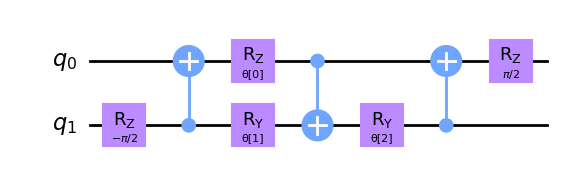

In [17]:
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")

Here is an example of the convolutional layer applied with 4 qubits.

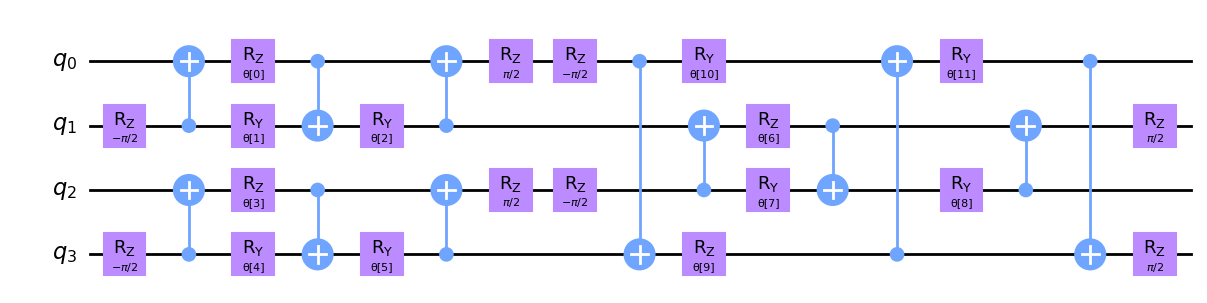

In [18]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl", style="clifford")

## Pooling Circuit
The pooling circuit takes information from two qubits and pools that information onto one qubit. By doing this, we can reduce the amount of qubits operated on by a factor of two after each convolution.

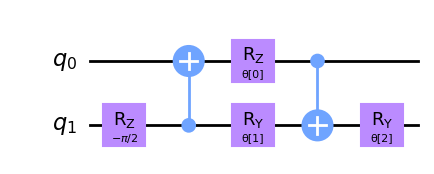

In [19]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

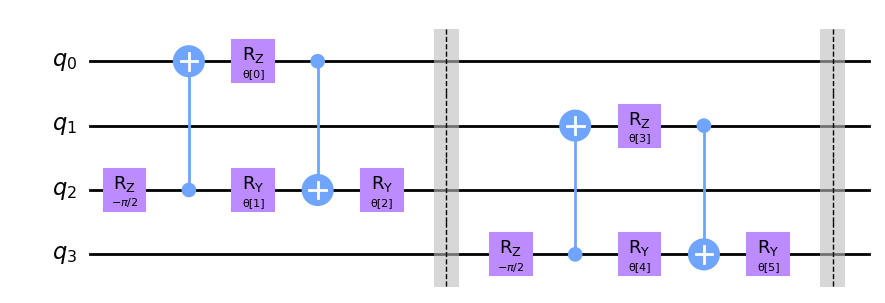

In [20]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

## Creating the Quantum Circuit
Now, once we have defined the quantum convolutional and pooling stages, we build our circuit, using 16 inputs and one output for binary classification.

In [36]:
feature_map = ZFeatureMap(16)

ansatz = QuantumCircuit(16, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(16, "c1"), list(range(16)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer(list(range(8)), list(range(8,16)), "p1"), list(range(16)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(8, "c2"), list(range(8, 16)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p2"), list(range(8, 16)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(4, "c3"), list(range(12, 16)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p3"), list(range(12, 16)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c4"), list(range(14, 16)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p4"), list(range(14, 16)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(16)
circuit.compose(feature_map, range(16), inplace=True)
circuit.compose(ansatz, range(16), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 15, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

In [28]:
# Uncomment the following line to view the circuit
# ansatz.draw("mpl", style="clifford")


## Setting up the Neural Network
Now we create the neural network, and set up our output and optimizer.

In [29]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [30]:
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),  # Set max iterations here
    callback=callback_graph,
)

In [31]:
x = np.asarray(x_train)
y = np.asarray(y_train)
labels = []
for i in y:
    labels.append(y[i])
labels = np.asarray(labels)
type(y[0])

numpy.int64

In [32]:
x_train.shape

(89, 16)

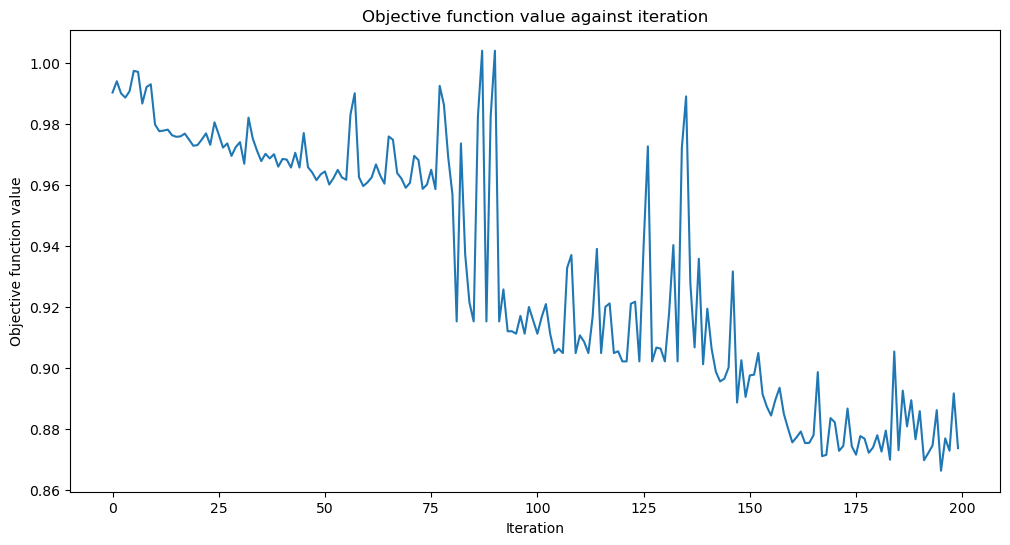

Accuracy from the train data : 83.15%


In [33]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x_train, y_train)

print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

In [34]:
x = np.asarray(x_test)
y = np.asarray(y_test)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

Accuracy from the test data : 18.18%


# Conclusions
I believe that the model needs a longer training time with more iterations. However, this is a good preliminary result, as the dataset is known to be difficult to classify, and the model does not seem to be converging anytime soon.

